# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [56]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier

% matplotlib inline
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
print(sns.__version__)
#seaborn 0.9.0 needed

0.9.0


In [2]:
#looking at the table sizes
print('portfolio shape: ',portfolio.shape)
print('profile shape: ',profile.shape)
print('transcript shape: ',transcript.shape)

portfolio shape:  (10, 6)
profile shape:  (17000, 5)
transcript shape:  (306534, 4)


### Looking at the data

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


### Transforming portfolio data to be suitable for machine learning
This is more efficient than merging it onto larger datasets and transforming later on more records

In [6]:
portfolio_transformed = portfolio.copy()
#getting unique channels used
channels = set()
for row in portfolio['channels']:
    channels.update(set(row))

#Creating dummy variables for channels
for channel in channels:
    portfolio_transformed[channel] = 0
    
row_index = 0
for row in portfolio_transformed['channels']:
    col_index = 6
    for channel in channels:
        if channel in set(row):
            portfolio_transformed.iloc[row_index,col_index] = 1
        col_index += 1
    row_index += 1
#Creating dummy variables for offer_type
offer_dummies = pd.get_dummies(portfolio_transformed['offer_type'])
portfolio_transformed = pd.concat([portfolio_transformed, offer_dummies], axis=1)
#dropping columns that are no longer needed
portfolio_transformed.drop(['channels','offer_type'],axis=1,inplace=True)
portfolio_transformed

,difficulty,duration,id,reward,web,email,social,mobile,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,0,1,0,1,0


### Looking at the profile data

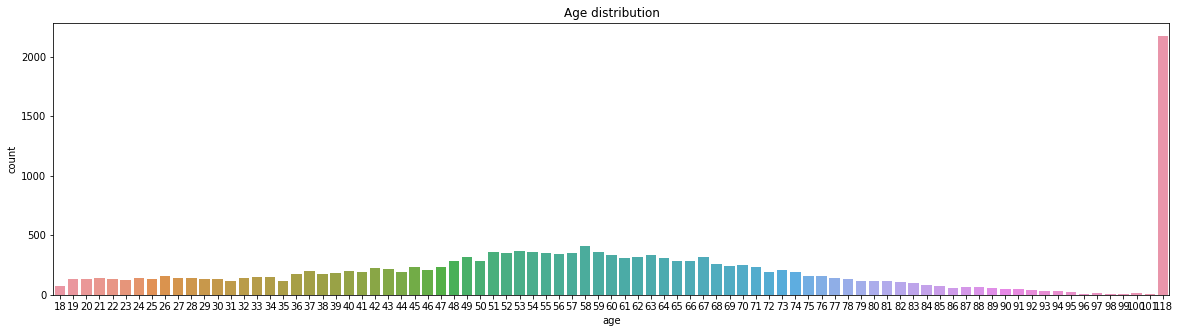

In [7]:
#Looking at the age variable
plt.figure(figsize=(20,5))
ax = sns.countplot(x='age', data=profile).set_title('Age distribution')

In [9]:
#Looking at the cumulative distribution for age
profile_not_118 = profile[profile['age'] != 118]
counts = pd.DataFrame(profile_not_118['age'].value_counts())
counts.sort_index(inplace=True)
counts['cumsum'] = counts['age'].cumsum()
counts['cumper'] = counts['cumsum']/profile_not_118.shape[0]
counts['cumper_inv'] = 1- counts['cumper']
counts.columns = ['Age counts','Cumulative', 'Cumulative percentage','Inverse cumulative percentage']
counts
#over a quarter of the customers are 66 or over (24.97%), which is bigger than the 18 to 41 group (23.55%)
#There are also more customers 80 or over (7.4%) than there are 18 to 25 year olds (6.8%)

,Age counts,Cumulative,Cumulative percentage,Inverse cumulative percentage
18,70,70,0.004722,0.995278
19,135,205,0.013828,0.986172
20,135,340,0.022934,0.977066
21,140,480,0.032378,0.967622
22,131,611,0.041214,0.958786
23,126,737,0.049713,0.950287
24,139,876,0.059089,0.940911
25,136,1012,0.068263,0.931737
26,157,1169,0.078853,0.921147
27,139,1308,0.088229,0.911771


In [10]:
#The age 118 seems to being used as a dummy value
#Setting this to null
profile['age'] = profile.age.apply(lambda x: np.nan if x == 118 else x)
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


##### Looking at the null values

In [11]:
#Proportion of null values
print('percentage of nulls')
print(profile.isnull().sum(axis=0)/profile.shape[0])
#Proportion of nulls where age is null
print()
print('percentage of nulls where age is null')
profile[profile['age'].isnull()].isnull().sum(axis=0)/profile[profile['age'].isnull()].shape[0]

percentage of nulls
age                 0.127941
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

percentage of nulls where age is null


age                 1.0
became_member_on    0.0
gender              1.0
id                  0.0
income              1.0
dtype: float64

The above shows that around 12.8% of the values are missing, and when age, gender or income are missing they all are.

In [12]:
#Converting the became a member integer to the days since the first member so that it can be scaled properly
first_date, last_date = pd.to_datetime(profile['became_member_on'].agg(['min','max']), format='%Y%m%d')
print('first date', first_date)
print('last date', last_date)
profile['days_from_first_member'] = (pd.to_datetime(profile['became_member_on'], format='%Y%m%d') - first_date).dt.days
profile.drop('became_member_on',axis=1,inplace=True)
profile.head()

first date 2013-07-29 00:00:00
last date 2018-07-26 00:00:00


,age,gender,id,income,days_from_first_member
0,NaN,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1294
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1447
2,NaN,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1809
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1380
4,NaN,None,a03223e636434f42ac4c3df47e8bac43,NaN,1467


##### checking to see if the null values are restricted to just a few days

In [13]:
#checking to see if the null values come from particular membership days
print("For nulls\n", profile[profile['age'].isnull()]['days_from_first_member'].agg(['min','max','mean','std']))
print("\nFor populated\n", profile[~profile['age'].isnull()]['days_from_first_member'].agg(['min','max','mean','std']))

For nulls
 min        4.000000
max     1823.000000
mean    1339.828966
std      350.201317
Name: days_from_first_member, dtype: float64

For populated
 min        0.000000
max     1823.000000
mean    1300.521012
std      419.205158
Name: days_from_first_member, dtype: float64


There doesn't seem to be any pattern for the nulls and the days the members were on-boarded.
Will wait till later for imputation to see if there are other differences when merged to other data

#### Looking at Gender

In [14]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Creating a binary variable for female or not. If we hot encoded it then it may cause issues with multi-colinearity, and because Male is the biggest group, adding other to it shouldn't skew it too much

In [15]:
profile['female'] = (profile['gender'] == 'F')
profile.drop('gender',axis=1,inplace=True)
profile.head(10)

,age,id,income,days_from_first_member,female
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1294,False
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,1447,True
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,1809,False
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1380,True
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,1467,False
5,68.0,e2127556f4f64592b11af22de27a7932,70000.0,1732,False
6,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,1519,False
7,NaN,68617ca6246f4fbc85e91a2a49552598,NaN,1526,False
8,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,1656,False
9,NaN,8974fc5686fe429db53ddde067b88302,NaN,1212,False


Since the other gender pot is relatively small, we will change this to a boolean field of Male or not.
This will have the effect of putting null values and females in the same bucket, but these can be further split out later with a seperate field to say if the values weren't captured.

In [16]:
#clustering
#will make null values its own cluster
profile_not_null = profile[~profile['income'].isnull()].copy()
profile_not_null.head()

,age,id,income,days_from_first_member,female
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,1447,True
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1380,True
5,68.0,e2127556f4f64592b11af22de27a7932,70000.0,1732,False
8,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,1656,False
12,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1566,False


In [17]:
#scaling age, income and days_from_first_member
fields_to_transform = ['age','income','days_from_first_member']
scaler = MinMaxScaler()
scaler.fit(profile_not_null[fields_to_transform])
transformed_values = scaler.transform(profile_not_null[fields_to_transform])
profile_not_null[fields_to_transform] = transformed_values
profile_not_null.head()

,age,id,income,days_from_first_member,female
1,0.445783,0610b486422d4921ae7d2bf64640c50b,0.911111,0.793747,True
3,0.686747,78afa995795e4d85b5d9ceeca43f5fef,0.777778,0.756994,True
5,0.602410,e2127556f4f64592b11af22de27a7932,0.444444,0.950082,False
8,0.566265,389bc3fa690240e798340f5a15918d5c,0.255556,0.908393,False
12,0.481928,2eeac8d8feae4a8cad5a6af0499a211d,0.233333,0.859024,False


### Using minibatch kmeans to work out how many clusters

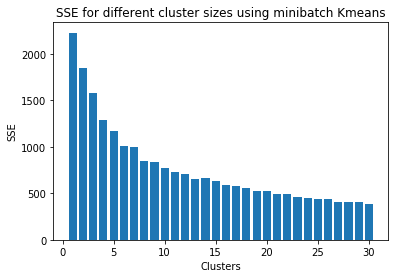

In [21]:

def get_kmeans_score(data, center, clf):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
        clf - the model to use (reccomend MiniBatchKMeans for testing, then kmeans)
    OUTPUT:
        score - the SSE score for the model fit to the data
    '''
    #instantiate kmeans
    #kmeans = MiniBatchKMeans(n_clusters=center)
    clf_inst = clf(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = clf_inst.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

profile_for_clustering = profile_not_null.drop('id',axis=1,inplace=False)
profile_for_clustering = profile_not_null.drop('id',axis=1,inplace=False)
score_list = []
centres = [i + 1 for i in range(30)]
for centre in centres:
    score_list.append(get_kmeans_score(profile_for_clustering, centre + 1, MiniBatchKMeans))
plt.bar(centres, score_list, align='center')
plt.title('SSE for different cluster sizes using minibatch Kmeans')
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.savefig("pictures/elbow_graph.png")
plt.show()
#Take 6

In [19]:
#Using full kmeans for 6 clusters
clf = KMeans(n_clusters=6)

# Then fit the model to your data using the fit method
model = clf.fit(profile_for_clustering)

# Obtain a score related to the model fit
score = np.abs(model.score(profile_for_clustering))
score

1115.7669463805987

In [36]:
#saving model so that if we re-run it the groups won't change number
dump(model, 'profile_cluster_model.joblib') 

['profile_cluster_model.joblib']

In [22]:
model = load('profile_cluster_model.joblib') 

In [23]:
profile_not_null['groups'] = model.predict(profile_for_clustering)
print(profile_not_null['groups'].value_counts())
profile_not_null.head()

2    3167
1    2962
4    2483
0    2350
3    2077
5    1786
Name: groups, dtype: int64


,age,id,income,days_from_first_member,female,groups
1,0.445783,0610b486422d4921ae7d2bf64640c50b,0.911111,0.793747,True,2
3,0.686747,78afa995795e4d85b5d9ceeca43f5fef,0.777778,0.756994,True,2
5,0.602410,e2127556f4f64592b11af22de27a7932,0.444444,0.950082,False,0
8,0.566265,389bc3fa690240e798340f5a15918d5c,0.255556,0.908393,False,0
12,0.481928,2eeac8d8feae4a8cad5a6af0499a211d,0.233333,0.859024,False,0


In [24]:
centres_df = pd.DataFrame(model.cluster_centers_)
centres_df.columns = ['age','income','days_from_first_member','female']
centres_df

,age,income,days_from_first_member,female
0,0.563000,0.242253,0.848624,-3.219647e-15
1,0.373238,0.256032,0.726009,1.000000e+00
2,0.572972,0.648753,0.711497,1.000000e+00
3,0.522961,0.646795,0.734291,-3.219647e-15
4,0.189351,0.232761,0.839572,-2.775558e-15
5,0.393316,0.296294,0.318386,-3.219647e-15


### Plotting the groups in scatterplots

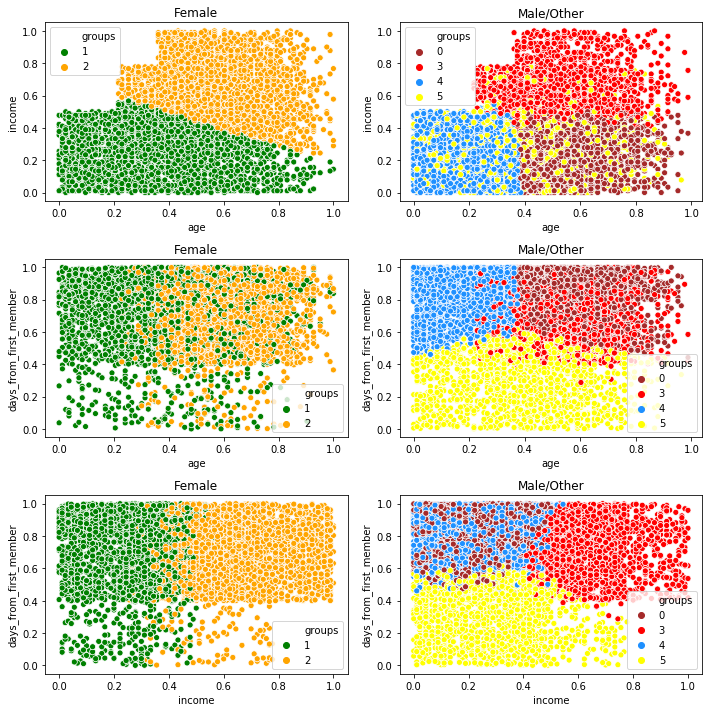

In [26]:
plt.figure(figsize=(10,10))

#fixing each group to a colour
color_dict = dict({0:'brown',
                  1:'green',
                  2: 'orange',
                  3: 'red',
                  4: 'dodgerblue',
                  5: 'yellow'})
#plotting scattergraphs
plt.subplot(3,2,1)
ax = sns.scatterplot(x="age"
                     ,y="income"
                     ,hue="groups"
                     #,style="female"
                     ,palette=color_dict
                     , data=profile_not_null[profile_not_null['female'] == True]).set_title('Female')
plt.subplot(3,2,2)
ax = sns.scatterplot(x="age"
                     ,y="income"
                     ,hue="groups"
                     #,style="female"
                     ,palette=color_dict
                     , data=profile_not_null[profile_not_null['female'] == False]).set_title('Male/Other')
plt.subplot(3,2,3)
ax = sns.scatterplot(x="age"
                     ,y="days_from_first_member"
                     ,hue="groups"
                     #,style="female"
                     ,palette=color_dict
                     , data=profile_not_null[profile_not_null['female'] == True]).set_title('Female')
plt.subplot(3,2,4)
ax = sns.scatterplot(x="age"
                     ,y="days_from_first_member"
                     ,hue="groups"
                     #,style="female"
                     ,palette=color_dict
                     , data=profile_not_null[profile_not_null['female'] == False]).set_title('Male/Other')
plt.subplot(3,2,5)
ax = sns.scatterplot(x="income"
                     ,y="days_from_first_member"
                     ,hue="groups"
                     #,style="female"
                     ,palette=color_dict
                     , data=profile_not_null[profile_not_null['female'] == True]).set_title('Female')
plt.subplot(3,2,6)
ax = sns.scatterplot(x="income"
                     ,y="days_from_first_member"
                     ,hue="groups"
                     #,style="female"
                     ,palette=color_dict
                     , data=profile_not_null[profile_not_null['female'] == False]).set_title('Male/Other')

plt.tight_layout()
plt.savefig("pictures/demographic_groups.png")
plt.show()

Cluster 1 - Female, lower income

Cluster 2 - Female, higher income

Cluster 0 - Older Male, lower income, newer member

Cluster 3 - Male, higher income, newer member

Cluster 4 - Youger male, lower income, newer member

Cluster 5 - Male, older member

In [27]:
#merging the group back onto main dataset
profile = profile.merge(profile_not_null[['id','groups']],how='left',left_on='id',right_on='id')
max_group = profile['groups'].max()
profile['groups'] = profile['groups'].fillna(max_group + 1)
profile.head()

,age,id,income,days_from_first_member,female,groups
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1294,False,6.0
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,1447,True,2.0
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,1809,False,6.0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1380,True,2.0
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,1467,False,6.0


### Transforming the transcript data

In [28]:
#splitting out the value field
value_splits = json_normalize(transcript['value'])
all_events_df = pd.concat([transcript, value_splits], axis=1)
all_events_df.head()

,event,person,time,value,amount,offer id,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


Checking what values are recorded for what events

In [29]:
event_counts = transcript.event.value_counts()

cols_to_check = ['amount','offer id','offer_id','reward']

nulls = all_events_df[cols_to_check].isnull()
nulls_by_event = pd.concat([all_events_df['event'], nulls], axis=1)
nulls_by_event = nulls_by_event.groupby('event').sum()
nulls_by_event = pd.concat([nulls_by_event, event_counts], axis=1, sort=True)

for col in cols_to_check:
    nulls_by_event[col] = nulls_by_event[col]/nulls_by_event['event']

nulls_by_event

,amount,offer id,offer_id,reward,event
offer completed,1.0,1.0,0.0,0.0,33579
offer received,1.0,0.0,1.0,1.0,76277
offer viewed,1.0,0.0,1.0,1.0,57725
transaction,0.0,1.0,1.0,1.0,138953


The above tables shows:
- Transactions only have amount values
- Offers viewed only have 'offer id' values
- Offers recevied only have 'offer id' values
- Offers completed have both 'offer_id' and 'reward'
- There are no missing values for the fields connected to each event

### Splitting out the events into 4 distinct tables
This will make it easier to review the data, and merge them together

In [30]:
#Transaction table
transaction_df = all_events_df[all_events_df['event'] == 'transaction'].copy()
transaction_df = transaction_df[['person','time','amount']].reset_index(drop=True)
#Creating unique key for each transaction
transaction_df['tran_id'] = (transaction_df['person'] 
                             + "_" + transaction_df['time'].map(str) 
                             + "_" + transaction_df['amount'].round(2).map(str)
                            )
transaction_df = transaction_df[['tran_id','person','time','amount']]
print('Transaction Table')
transaction_df.head()

Transaction Table


,tran_id,person,time,amount
0,02c083884c7d45b39cc68e1314fec56c_0_0.83,02c083884c7d45b39cc68e1314fec56c,0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f_0_34.56,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
2,54890f68699049c2a04d415abc25e717_0_13.23,54890f68699049c2a04d415abc25e717,0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2_0_19.51,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52_0_18.97,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [31]:
#received table
received_df = all_events_df[all_events_df['event'] == 'offer received'].copy()
received_df = received_df[['person','time','offer id']].rename(columns={"offer id": "offer_id"}).reset_index(drop=True)
#merging on duration to received table
received_df = received_df.merge(portfolio[['id','duration']],how='left', left_on='offer_id', right_on='id')
received_df.drop('id',axis=1,inplace=True)
#Creating a unique key to track the event of each promotional mateirial being sent
received_df['marketing_id'] = (received_df['person'] 
                             + "_" + received_df['time'].map(str)
                             + "_" + received_df['offer_id']
                            )
received_df = received_df[['marketing_id','person','time','duration','offer_id']]
print('Received Table: {0} records'.format(received_df.shape[0]))
received_df.head()

Received Table: 76277 records


,marketing_id,person,time,duration,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef_0_9b98b8c7a33...,78afa995795e4d85b5d9ceeca43f5fef,0,7,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43_0_0b1e1539f2c...,a03223e636434f42ac4c3df47e8bac43,0,10,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932_0_2906b810c7d...,e2127556f4f64592b11af22de27a7932,0,7,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586_0_fafdcd668e3...,8ec6ce2a7e7949b1bf142def7d0e0586,0,10,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598_0_4d5c57ea9a6...,68617ca6246f4fbc85e91a2a49552598,0,5,4d5c57ea9a6940dd891ad53e9dbe8da0


In [32]:
#viewed table
viewed_df = all_events_df[all_events_df['event'] == 'offer viewed'].copy()
viewed_df = viewed_df[['person','time','offer id']].rename(columns={"offer id": "offer_id"}).reset_index(drop=True)
print('Views Table: {0} records'.format(viewed_df.shape[0]))
viewed_df.head()

Views Table: 57725 records


,person,time,offer_id
0,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
1,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
2,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
3,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
4,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837


In [33]:
#completed table
completed_df = all_events_df[all_events_df['event'] == 'offer completed'].copy()
completed_df = completed_df[['person','time','offer_id','reward']].reset_index(drop=True)
print('Completion Table: {0} records'.format(completed_df.shape[0]))
completed_df.head()

Completion Table: 33579 records


,person,time,offer_id,reward
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,2.0
1,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,2.0
2,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
3,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,10.0
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0


### Appending information to the received table
This will allow us to measure the effectiveness of each material sent to each individual

In [34]:
#creating dataframe of merged received and viewed tables
received_viewed_df = pd.merge(received_df[['marketing_id','person','time','duration','offer_id']]
                            ,viewed_df
                           ,on=['person','offer_id']
                           ,how='inner')
#adding flag to say if it was viewed while the promotion was active
received_viewed_df['In Scope'] = ((received_viewed_df['time_y'] >= received_viewed_df['time_x']) #saying it must be viewed after it was received
                                     & (received_viewed_df['time_y'] <= (received_viewed_df['time_x'] 
                                                                              + (received_viewed_df['duration']*24)
                                                                             )#saying it should be viewed within the duration the material is active for
                                       )
                                  )
#Adding field to origional received df to say if it was viewed in time
viewed_in_time = received_viewed_df[received_viewed_df['In Scope']]['marketing_id'].unique()
received_df['viewed_in_time'] = received_df['marketing_id'].isin(viewed_in_time)
received_df.head()

,marketing_id,person,time,duration,offer_id,viewed_in_time
0,78afa995795e4d85b5d9ceeca43f5fef_0_9b98b8c7a33...,78afa995795e4d85b5d9ceeca43f5fef,0,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,True
1,a03223e636434f42ac4c3df47e8bac43_0_0b1e1539f2c...,a03223e636434f42ac4c3df47e8bac43,0,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,True
2,e2127556f4f64592b11af22de27a7932_0_2906b810c7d...,e2127556f4f64592b11af22de27a7932,0,7,2906b810c7d4411798c6938adc9daaa5,True
3,8ec6ce2a7e7949b1bf142def7d0e0586_0_fafdcd668e3...,8ec6ce2a7e7949b1bf142def7d0e0586,0,10,fafdcd668e3743c1bb461111dcafc2a4,True
4,68617ca6246f4fbc85e91a2a49552598_0_4d5c57ea9a6...,68617ca6246f4fbc85e91a2a49552598,0,5,4d5c57ea9a6940dd891ad53e9dbe8da0,True


In [35]:
#creating dataframe of merged received and completed tables
received_completed_df = pd.merge(received_df[['marketing_id','person','time','duration','offer_id']]
                            ,completed_df
                           ,on=['person','offer_id']
                           ,how='inner')
#adding flag to say if it was viewed while the promotion was completed
received_completed_df['In Scope'] = ((received_completed_df['time_y'] >= received_completed_df['time_x'])
                                     & (received_completed_df['time_y'] <= (received_completed_df['time_x'] 
                                                                              + (received_completed_df['duration']*24)
                                                                             )
                                       )
                                  )
#Adding field to origional received df to say if it was viewed in time
completed_in_time = received_completed_df[received_completed_df['In Scope']]['marketing_id'].unique()
received_df['completed_in_time'] = received_df['marketing_id'].isin(completed_in_time)
received_df.head()

,marketing_id,person,time,duration,offer_id,viewed_in_time,completed_in_time
0,78afa995795e4d85b5d9ceeca43f5fef_0_9b98b8c7a33...,78afa995795e4d85b5d9ceeca43f5fef,0,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True
1,a03223e636434f42ac4c3df47e8bac43_0_0b1e1539f2c...,a03223e636434f42ac4c3df47e8bac43,0,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False
2,e2127556f4f64592b11af22de27a7932_0_2906b810c7d...,e2127556f4f64592b11af22de27a7932,0,7,2906b810c7d4411798c6938adc9daaa5,True,False
3,8ec6ce2a7e7949b1bf142def7d0e0586_0_fafdcd668e3...,8ec6ce2a7e7949b1bf142def7d0e0586,0,10,fafdcd668e3743c1bb461111dcafc2a4,True,False
4,68617ca6246f4fbc85e91a2a49552598_0_4d5c57ea9a6...,68617ca6246f4fbc85e91a2a49552598,0,5,4d5c57ea9a6940dd891ad53e9dbe8da0,True,False


In [36]:
#Adding a final tag for where the promotion was both viewed and completed
received_df['final_completed'] = received_df['completed_in_time'] & received_df['viewed_in_time']
received_df.head()

,marketing_id,person,time,duration,offer_id,viewed_in_time,completed_in_time,final_completed
0,78afa995795e4d85b5d9ceeca43f5fef_0_9b98b8c7a33...,78afa995795e4d85b5d9ceeca43f5fef,0,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,True
1,a03223e636434f42ac4c3df47e8bac43_0_0b1e1539f2c...,a03223e636434f42ac4c3df47e8bac43,0,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False,False
2,e2127556f4f64592b11af22de27a7932_0_2906b810c7d...,e2127556f4f64592b11af22de27a7932,0,7,2906b810c7d4411798c6938adc9daaa5,True,False,False
3,8ec6ce2a7e7949b1bf142def7d0e0586_0_fafdcd668e3...,8ec6ce2a7e7949b1bf142def7d0e0586,0,10,fafdcd668e3743c1bb461111dcafc2a4,True,False,False
4,68617ca6246f4fbc85e91a2a49552598_0_4d5c57ea9a6...,68617ca6246f4fbc85e91a2a49552598,0,5,4d5c57ea9a6940dd891ad53e9dbe8da0,True,False,False


In [37]:
#Looking at the proportion of each event that happens after the promotional material is sent
received_df[['viewed_in_time','completed_in_time','final_completed']].sum()/received_df.shape[0]

viewed_in_time       0.745900
completed_in_time    0.440906
final_completed      0.365733
dtype: float64

The above shows that 74.5% of the promotions were viewed within the applicable timeframe, 44% were completed, and 36.5% were both completed and viewed.

### Merging on personal and offer features

In [38]:
offers_cleaned = received_df.merge(portfolio_transformed[['id','difficulty','reward','social'
                                                       ,'mobile','web','email','bogo','discount','informational']]
                                ,how='left'
                                , left_on='offer_id'
                                , right_on='id')
offers_cleaned.drop('id',axis=1,inplace=True)
offers_cleaned = offers_cleaned.merge(profile[['id','age','days_from_first_member','female','income','groups']]
                                ,how='left'
                                , left_on='person'
                                , right_on='id')

offers_cleaned = offers_cleaned[['final_completed','completed_in_time','duration','difficulty','reward','social'
                                 ,'mobile','web','email','bogo','discount','informational','age','days_from_first_member'
                                 ,'female','income','groups']]
offers_cleaned['profile_null'] = offers_cleaned.age.isnull()
offers_cleaned.to_pickle('offers_cleaned.pickle')
offers_cleaned.head()

,final_completed,completed_in_time,duration,difficulty,reward,social,mobile,web,email,bogo,discount,informational,age,days_from_first_member,female,income,groups,profile_null
0,True,True,7,5,5,0,1,1,1,1,0,0,75.0,1380,True,100000.0,2.0,False
1,False,False,10,20,5,0,0,1,1,0,1,0,NaN,1467,False,NaN,6.0,True
2,False,False,7,10,2,0,1,1,1,0,1,0,68.0,1732,False,70000.0,0.0,False
3,False,False,10,10,2,1,1,1,1,0,1,0,NaN,1519,False,NaN,6.0,True
4,False,False,5,10,10,1,1,1,1,1,0,0,NaN,1526,False,NaN,6.0,True


In [2]:
offers_cleaned = pd.read_pickle('offers_cleaned.pickle')
offers_cleaned.head()

,final_completed,completed_in_time,duration,difficulty,reward,social,mobile,web,email,bogo,discount,informational,age,days_from_first_member,female,income,groups,profile_null
0,True,True,7,5,5,0,1,1,1,1,0,0,75.0,1380,True,100000.0,2.0,False
1,False,False,10,20,5,0,0,1,1,0,1,0,NaN,1467,False,NaN,6.0,True
2,False,False,7,10,2,0,1,1,1,0,1,0,68.0,1732,False,70000.0,0.0,False
3,False,False,10,10,2,1,1,1,1,0,1,0,NaN,1519,False,NaN,6.0,True
4,False,False,5,10,10,1,1,1,1,1,0,0,NaN,1526,False,NaN,6.0,True


### Checking if the population with missing demographic data is similar to the others

In [3]:
#Splitting up the null and not null populations
#Looking at where the income, gender and age are missing
null_pop = offers_cleaned[offers_cleaned.profile_null].copy()
null_pop.drop('profile_null',axis=1,inplace=True)
#Looking at where the income, gender and age are not missing
not_null_pop = offers_cleaned[~offers_cleaned.profile_null].copy()
not_null_pop.drop('profile_null',axis=1,inplace=True)
#putting the two populations into a list
compare_pops = [null_pop,not_null_pop]

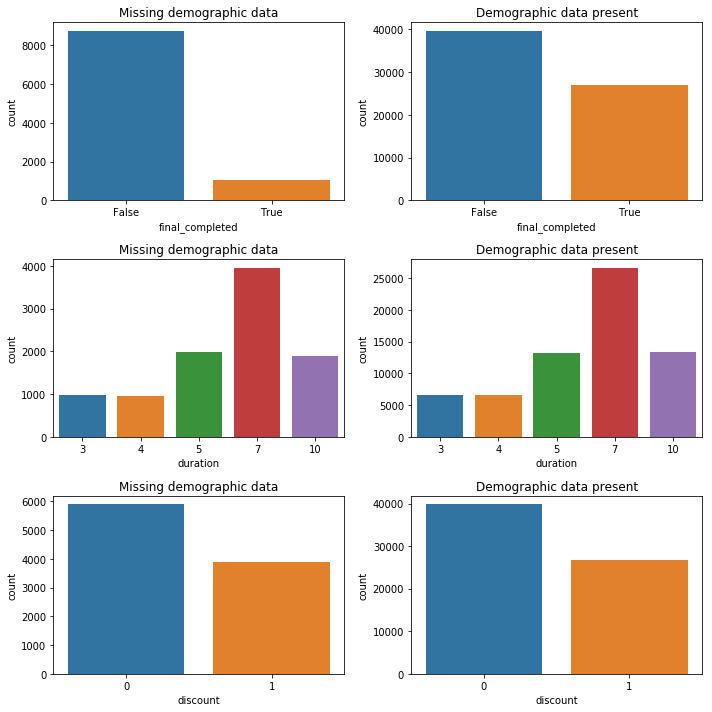

Proportion completed in null population 0.105564648118
Proportion completed with no nulls 0.403978887536


In [4]:
#Plotting key variables for the two populations to look for differences
title_list = ['Missing demographic data','Demographic data present']

def compare_populations(population_list,cols_to_check):
    """
    Input:population_list - A list of dataframes containing different populations that you want to compare.
                          - Graphs will be output for each population
          cols_to_check   - The fields that you want to use countplot on to graph for each population
    """
    plt.figure(figsize=(10,10))
    graph_rows = len(cols_to_check)
    graph_cols = len(population_list)
    for row_index, col in enumerate(cols_to_check):
        for col_index, population in enumerate(population_list):
            index = (row_index*graph_cols + col_index) + 1
            plt.subplot(graph_rows,graph_cols,index)
            ax = sns.countplot(x=col, data=population).set_title(title_list[col_index])
    plt.tight_layout()
    plt.savefig("pictures/missing_comparisons.png")
    plt.show()
compare_populations(compare_pops,['final_completed','duration','discount'])
print("Proportion completed in null population",null_pop['final_completed'].sum()/null_pop.shape[0])
print("Proportion completed with no nulls",not_null_pop['final_completed'].sum()/not_null_pop.shape[0])

The above tables show that while the promotions sent out were equally distributed between the two populations, the take up rate is markably different.
Therefore imputation will not be used, and they will be treated seperatly.

In [4]:
#scaling age, income and days_from_first_member
scaler = MinMaxScaler()
scaler.fit(not_null_pop)
transformed_values = scaler.transform(not_null_pop)
not_null_pop[not_null_pop.columns] = transformed_values
#unconverting the groups
not_null_pop.groups = not_null_pop.groups*5
#deleting email as it is in all offers
not_null_pop.drop('email',axis=1,inplace=True)
not_null_pop.head()

,final_completed,completed_in_time,duration,difficulty,reward,social,mobile,web,bogo,discount,informational,age,days_from_first_member,female,income,groups
0,1.0,1.0,0.571429,0.25,0.5,0.0,1.0,1.0,1.0,0.0,0.0,0.686747,0.756994,1.0,0.777778,2.0
2,0.0,0.0,0.571429,0.50,0.2,0.0,1.0,1.0,0.0,1.0,0.0,0.602410,0.950082,0.0,0.444444,0.0
5,1.0,1.0,0.285714,0.25,0.5,1.0,1.0,1.0,1.0,0.0,0.0,0.566265,0.908393,0.0,0.255556,0.0
7,0.0,0.0,0.142857,0.00,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.481928,0.859024,0.0,0.233333,0.0
8,0.0,0.0,1.000000,1.00,0.5,0.0,0.0,1.0,0.0,1.0,0.0,0.518072,0.825562,1.0,0.300000,1.0


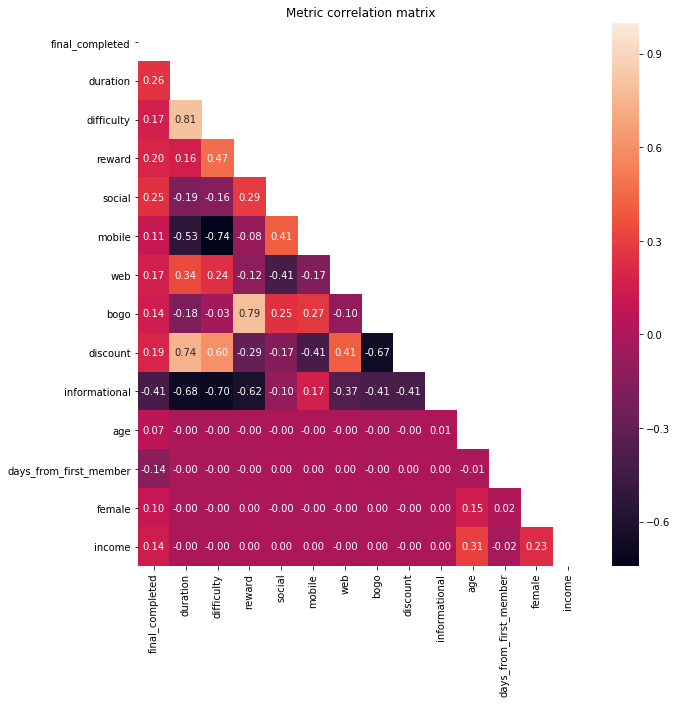

In [5]:
#checking the correlation matrix
data_to_model = not_null_pop.drop(['completed_in_time','groups'],axis=1).copy()
plt.figure(figsize=(10,10))
corr = data_to_model.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, annot=True, fmt='.2f', mask=mask).set_title('Metric correlation matrix')
plt.savefig("pictures/correlation_matrix.png")

The chance of someone using an offer looks to be impacted the most by the duration of the promotion.
Email is showing as NaN because all promotions included email, so we can drop this.

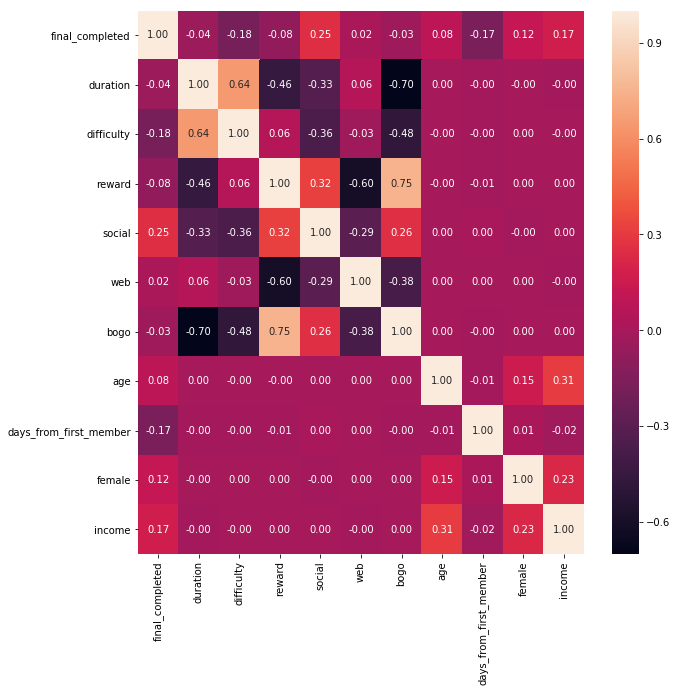

In [7]:
data_to_model = data_to_model[data_to_model['informational'] == 0]
data_to_model.drop(['informational','discount','mobile'],axis=1,inplace=True)
plt.figure(figsize=(10,10))
ax = sns.heatmap(data_to_model.corr(), annot=True, fmt='.2f')

By removing informational campaigns, additional correlations became apparent. We will therefore keep everything in, but watch for the impact of correlations.

### Comparing distribution of groups amongst the offer population, completed population, and completed but didn't view population

In [8]:
def group_ratios(df):
    """Input: df - the dataframe containing the column called 'groups'
       Output: Series with the percentage of the rows in df belonging to each group
    """
    return df.groups.value_counts()/df.shape[0]

all_groups = group_ratios(offers_cleaned)
fully_comp_groups = group_ratios(offers_cleaned[offers_cleaned['final_completed']])
completed_not_viewed = group_ratios(offers_cleaned[offers_cleaned['completed_in_time'] 
                                                   & offers_cleaned['final_completed'] == False])
group_ratios = pd.concat([all_groups, fully_comp_groups, completed_not_viewed], axis=1)
group_ratios.columns = ['All','Completed + Viewed','Completed Not Viewed']
group_ratios.index = group_ratios.index.astype(int)
group_ratios.style.format({
    'All': '{:,.1%}'.format
    ,'Completed + Viewed': '{:,.1%}'.format
    ,'Completed Not Viewed': '{:,.1%}'.format
})

,All,Completed + Viewed,Completed Not Viewed
0,13.8%,11.2%,15.3%
1,17.5%,20.6%,15.7%
2,18.5%,24.7%,15.0%
3,12.3%,16.4%,9.9%
4,14.6%,11.0%,16.6%
5,10.5%,12.4%,9.4%
6,12.8%,3.7%,18.1%


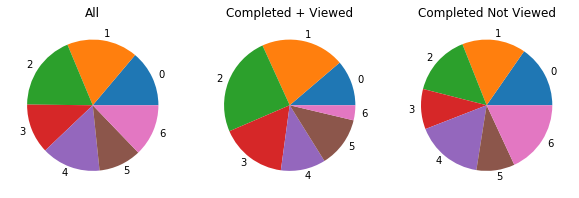

In [9]:
#Displaying as piechars
fig, axes = plt.subplots(1,3, figsize=(10,5))
for ax, col in zip(axes, group_ratios.columns):
    ax.pie(group_ratios[col], labels=group_ratios.index)
    ax.set(ylabel='', title=col, aspect='equal')
plt.savefig("pictures/groups_by_outcomes.png")

### Modelling to see how much variation in using the offers we can explain from the fields we have

The datasets are already sorted. We will therefore take the first 80% of the records for our training population, and the last 20% as our test population. This ensures that our testing population will be closer to the outcomes in any live environment, as the customers will be a bit aged from the training data.

In [10]:
#Checking if the groups are balanced
not_null_pop[['groups','final_completed']].groupby('groups').agg(['count','sum'])

final_completed        
                 count     sum
groups                        
0.0              10562  3136.0
1.0              13315  5736.0
2.0              14141  6884.0
3.0               9351  4566.0
4.0              11103  3076.0
5.0               8029  3467.0

#### Modelling the combined demographic and offer type information

Not looking at rows with missing demographic data

In [9]:
data_to_model = not_null_pop.drop(['completed_in_time','groups'],axis=1).copy()
data_to_model.head()

,final_completed,duration,difficulty,reward,social,mobile,web,bogo,discount,informational,age,days_from_first_member,female,income
0,1.0,0.571429,0.25,0.5,0.0,1.0,1.0,1.0,0.0,0.0,0.686747,0.756994,1.0,0.777778
2,0.0,0.571429,0.50,0.2,0.0,1.0,1.0,0.0,1.0,0.0,0.602410,0.950082,0.0,0.444444
5,1.0,0.285714,0.25,0.5,1.0,1.0,1.0,1.0,0.0,0.0,0.566265,0.908393,0.0,0.255556
7,0.0,0.142857,0.00,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.481928,0.859024,0.0,0.233333
8,0.0,1.000000,1.00,0.5,0.0,0.0,1.0,0.0,1.0,0.0,0.518072,0.825562,1.0,0.300000


In [6]:
#splitting the data into train and testing datasets
def split_test_train(df,test_size):
    """
    Input: df - the dataset you want to split up
           test_size - a number between 0 and 1 that gives the proportion of the dataset to keep for testing
           
    Output: X_train the first n(1-test_size) rows with the first column taken out
            X_test the last n(test_size) rows with the first column taken out
            y_train the first n(1-test_size) rows with only the first column
            y_test the first n(test_size) rows with only the first column
            
    Other info: This assumes that there is a single dependent variable which is stored in the first column
                The test sample is taken to be those at the end rows of the dataset (assuming these are the newest)
    """
    cut_off = round(df.shape[0]*(1-test_size))
    X_train = df.iloc[0:cut_off,1:]
    X_test = df.iloc[cut_off:,1:]
    y_train = df.iloc[0:cut_off,0]
    y_test = df.iloc[cut_off:,0]
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = split_test_train(data_to_model,0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(53201, 13) (13300, 13) (53201,) (13300,)


In [7]:
def train_model(clf, importance_attribute, X_train, y_train, X_test, y_test):
    """
    input: clf - an instance of the classifier/model you want to use
           importance_attribute - the string of the model attribute that allows you to compare the impacts of variables
                                - this will be coef_ for regression, and feature_importances_ for others
           training and testing dataframes split by x and y
    output: accuracy - the accuracy of the model on the test data
            importance - the importance attribute for the trained model
    """
    model = clf
    model.fit(X_train, y_train)
    y_test_preds = model.predict(X_test) 
    accuracy = accuracy_score(y_test.values, y_test_preds)
    importance = getattr(model, importance_attribute)
    return accuracy, importance

def return_sample(X_train, y_train,sample_percent):
    """
    input: X_train, y_train - the X and y data that we want to sample
           sample_percent - the percentage of the data that you want to keep
    output: The X and y data which are randomly sampled
    other information: the X and Y data must have the same number of rows
                       It will return the same rows for both X and Y so they can still be used for modelling
    """
    random_mask = np.random.choice([False, True], X_train.shape[0], p=[sample_percent,1-sample_percent])
    X_new = X_train[random_mask]
    y_new = y_train[random_mask]
    return X_new, y_new

In [53]:
#Seeing how well the stock Logistic regression does
#Trying adaboost classifier
lr_results = train_model(LogisticRegression(),'coef_'
            ,X_train, y_train, X_test, y_test)
#From https://scikit-learn.org/stable/modules/cross_validation.html
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Training accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
print('Test Accuracy: %0.3f' % lr_results[0])

Training accuracy: 0.734 (+/- 0.005)
Test Accuracy: 0.732


#### Bootstrapping to get an idea of the variability of the coeficients

In [9]:
def train_samples(clf, importance_attribute, X_train, y_train, X_test, y_test, sample_percent,simulations):
    """
    Trains the input data on a sample, then gets the returned coefficients.
    It then repeats this n times to get an idea of how the coefficients change
    input: clf - an instance of the classifier/model you want to use
           importance_attribute - the string of the model attribute that allows you to compare the impacts of variables
                                - this will be coef_ for regression, and feature_importances_ for others
           training and testing dataframes split by x and y
           sample_percent - a decimal with the percentage of the rows that you want to keep in the sample
           simulations - an integer with the number of simulations to carry out
    output: A list with two objects.
            The first object is a dataframe containing the min, max and mean of each coeffienct accross all simulations
            The second object is a list of the accuracy of the model trained on sampled data for each simulation
    """
    accuracy_list = []
    importance_list = []
    for x in range(simulations):
        X_new, y_new = return_sample(X_train, y_train,sample_percent)
        results = train_model(clf,importance_attribute
                ,X_new, y_new, X_test, y_test)
        accuracy_list.append(results[0])
        if len(results[1]) == 1:
            importance_list.append(results[1][0])
        else:
            importance_list.append(results[1])
    significance = np.exp(pd.DataFrame(importance_list).T)
    column_names = ['sample {0}'.format(x) for x in significance.columns]
    significance.columns = column_names
    significance['variable'] = X_train.columns
    significance['mean'] = significance.mean(axis=1)
    significance['max'] = significance.max(axis=1)
    significance['min'] = significance.min(axis=1)
    significance.drop(column_names,axis=1,inplace=True)
    significance.sort_values(by=['mean'],inplace=True)
    significance.reset_index(drop=True,inplace=True)
    return significance, accuracy_list
sample_results_reg = train_samples(LogisticRegression(), 'coef_', X_train, y_train, X_test, y_test,0.25,20)
sample_results_reg[0]

,variable,mean,max,min
0,informational,0.002900,0.003006,0.002781
1,days_from_first_member,0.168681,0.176087,0.158993
2,difficulty,0.176075,0.209436,0.146475
3,reward,0.865086,0.983252,0.749554
4,age,1.336402,1.426664,1.259897
5,mobile,1.342827,1.460476,1.234613
6,web,1.360032,1.409007,1.313594
7,female,1.508651,1.556906,1.463215
8,duration,2.989763,3.246759,2.627519
9,social,3.345768,3.487051,3.224788


### Performing regression model on different groups

As the demographic information is already captured in the groups we are just keeping the offer information.
This means that we would be able to choose the best offers for the different groups

In [10]:
offer_columns = ['final_completed','duration','difficulty','reward'
                  ,'mobile','web','social','bogo','discount','informational']
results_list = []
groups = 7
for i in range(groups):
    group_df = offers_cleaned[offers_cleaned['groups'] == i][offer_columns]
    X_train, X_test, y_train, y_test = split_test_train(group_df ,0.2)
    results_lg = train_model(LogisticRegression(),'coef_'
                            ,X_train, y_train, X_test, y_test)
    results_list.append(np.append(np.exp(results_lg[1][0]),results_lg[0]))
significance = pd.DataFrame(results_list).T 
column_names = ['group {0}'.format(x) for x in significance.columns]
significance.columns = column_names
metrics = offer_columns[1:]
metrics.append('model accuracy')
significance['metric'] = metrics
#swapping columns orders to put metric first
column_names.insert(0,'metric')
significance = significance[column_names]
significance

,metric,group 0,group 1,group 2,group 3,group 4,group 5,group 6
0,duration,1.075708,1.182451,1.165794,1.137350,1.223421,1.365078,1.276840
1,difficulty,0.963587,0.873404,0.944293,0.971328,0.839492,0.858105,0.808624
2,reward,0.900149,1.046543,1.044179,0.989042,1.030813,0.928147,0.810573
3,mobile,1.213766,1.016175,2.015857,1.795708,0.570051,1.180611,0.395348
4,web,0.964738,1.300206,1.821816,1.564888,1.079659,1.819432,1.153854
5,social,2.726648,2.977530,3.865067,2.995930,2.803345,4.897781,2.736650
6,bogo,3.462719,2.905469,2.082884,2.596981,2.508034,2.203199,2.882446
7,discount,3.493516,5.680951,3.244831,3.085689,4.814139,4.251569,3.639080
8,informational,0.009067,0.006183,0.005889,0.008121,0.010124,0.006187,0.012583
9,model accuracy,0.715436,0.728502,0.760255,0.724599,0.735705,0.739726,0.903325


In [11]:
#Bootstrapping group 4 to see if the anomolous result on mobile could be due to chance
group_df = offers_cleaned[offers_cleaned['groups'] == 4][offer_columns]
X_train, X_test, y_train, y_test = split_test_train(group_df ,0.2)

sample_results_reg = train_samples(LogisticRegression(), 'coef_', X_train, y_train, X_test, y_test,0.25,20)
sample_results_reg[0]

,variable,mean,max,min
0,informational,0.012248,0.012859,0.011487
1,mobile,0.560360,0.674629,0.424327
2,difficulty,0.837116,0.854921,0.814355
3,reward,1.033844,1.061120,1.008600
4,web,1.068441,1.203867,0.911843
5,duration,1.225461,1.269814,1.169041
6,bogo,2.387694,2.878533,2.074786
7,social,2.744799,2.964670,2.531475
8,discount,4.639574,5.367962,3.732877


The above table shows that although there is a lot of variability in the mobile coefficient, the range of likely values still indicates a lower chance of completing.

### Looking at other models to see if we can improve on logistic regression

In [51]:
#splitting data to use whole data again
X_train, X_test, y_train, y_test = split_test_train(data_to_model,0.2)
#Trying adaboost classifier
ada_results = train_model(AdaBoostClassifier(),'feature_importances_'
            ,X_train, y_train, X_test, y_test)
#From https://scikit-learn.org/stable/modules/cross_validation.html
scores = cross_val_score(AdaBoostClassifier(), X_train, y_train, cv=5)
print("Training accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
print('Test Accuracy:',ada_results[0])

Training accuracy: 0.756 (+/- 0.005)
Test Accuracy: 0.753834586466


In [54]:
#Looking at random forest
rf_results = train_model(RandomForestClassifier(),'feature_importances_'
            ,X_train, y_train, X_test, y_test)
scores = cross_val_score(RandomForestClassifier(), X_train, y_train, cv=5)
print("Training accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
print('Test Accuracy:',rf_results[0])

Training accuracy: 0.755 (+/- 0.011)
Test Accuracy: 0.754285714286


In [32]:
#Add validation dataset
parameters = {'n_estimators':(10, 50, 100)
              , 'learning_rate':[0.1, 0.5, 1, 5, 10]
              , 'base_estimator':[DecisionTreeClassifier(max_depth=1)
                                , DecisionTreeClassifier(max_depth=2)
                                , DecisionTreeClassifier(max_depth=3)]
             }
ada = AdaBoostClassifier()
clf = GridSearchCV(ada, parameters, cv=3)
clf.fit(X_train, y_train)
print(clf.best_estimator_)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=100, random_state=None)


In [55]:
params = clf.cv_results_['params']
parameter_df = pd.DataFrame({'Accuracy':means,'Accuracy_STD':2*stds,'Parameters':params})
parameter_df.sort_values('Accuracy',ascending=False)

,Accuracy,Accuracy_STD,Parameters
32,0.770042,0.005424,{'base_estimator': DecisionTreeClassifier(clas...
34,0.769986,0.002527,{'base_estimator': DecisionTreeClassifier(clas...
35,0.769083,0.001669,{'base_estimator': DecisionTreeClassifier(clas...
33,0.768745,0.005052,{'base_estimator': DecisionTreeClassifier(clas...
31,0.768294,0.003178,{'base_estimator': DecisionTreeClassifier(clas...
20,0.767222,0.004436,{'base_estimator': DecisionTreeClassifier(clas...
19,0.766414,0.003892,{'base_estimator': DecisionTreeClassifier(clas...
23,0.766358,0.003191,{'base_estimator': DecisionTreeClassifier(clas...
22,0.766151,0.002728,{'base_estimator': DecisionTreeClassifier(clas...
17,0.765456,0.002070,{'base_estimator': DecisionTreeClassifier(clas...


In [49]:
#Checking the best estimator was chosen to be the top of the table
parameter_df.iloc[32]['Parameters']

{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'), 'learning_rate': 0.1, 'n_estimators': 100}

In [50]:
y_test_preds = clf.predict(X_test) 
print('Test Accuracy:',accuracy_score(y_test.values, y_test_preds))

Test Accuracy: 0.772781954887
